# SameSentiment - Yelp - Baseline - Vectors, Doc2Vec + SVM/LogReg/SGD

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
# ! pip install gensim

In [ ]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [ ]:
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
import csv

from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from utils import Timer

In [3]:
from utils import init_random
init_random()

In [4]:
# download + scp to server + extract
data_yelp_path = Path("data/sentiment/yelp/")

dn_yelp_cached = data_yelp_path / "cached"

---

In [ ]:
#  #### Load categories & topics
from data_prep import load_reviews, load_topics

# ##### Filter categories
from data_prep import filter_min_cat_combis, make_map_cats, make_cat_combis

# ##### Filter reviews
from data_prep import filter_min_review_freq, filter_both_good_bad

# ##### Filter businesses
from data_prep import filter_by_businesses, filter_by_businesses_not_same

# #### Load category tree
from data_prep import load_category_tree
from data_prep import get_root_category_items, get_children_category_item_list
from data_prep import get_businesses_in_category, get_businesses_in_category_branch


# #### Cache root category reviews in dataframes
from data_prep import cache_root_category_businesses_df, load_cached_root_category_businesses_df


# #### Positive + negative same-sentiment pairs
from data_prep import make_pairs_good_bad
from data_prep import make_pairs_good_bad_over_business

# #### Not same-sentiment pairs (combinations positive + negative)
from data_prep import make_pairs_negative
from data_prep import make_pairs_negative_over_business

# #### Dataframe for training etc.
from data_prep import make_or_load_pairs
from data_prep import make_or_load_pairs_over_businesses


# #### Make train/dev/test splits
from data_prep import split_df, write_pair_df_tsv, write_pair_tdt_tsv


---

# Baseline

### lemmatizing

In [26]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize


def get_wordnet_pos(treebank_tag):
    """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN


def lemmatize_stemming(token, pos_tag):
    stemmer = SnowballStemmer(
        "english")  # pOrter, M. "An algorithm for suffix stripping."
    return stemmer.stem(WordNetLemmatizer().lemmatize(token, pos=pos_tag))


def preprocess(text):
    lemma = []
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('\n', ' ').strip()
        tokens = [token for token in word_tokenize(sentence)]
        pos_tags = nltk.pos_tag(tokens)

        for idx in range(0, len(tokens)):
            token = tokens[idx].lower()
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(
                    token) > 3:
                wordnet_pos = get_wordnet_pos(pos_tags[idx][1])
                l_ = lemmatize_stemming(token, wordnet_pos)
                lemma.append(l_)
    return ' '.join(lemma)

In [27]:
def get_lemma(row):
    row['argument1_lemmas'] = preprocess(row['argument1'])
    row['argument2_lemmas'] = preprocess(row['argument2'])
    return row

### Extracting n grams lemma for argument1 and argument2

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def extract_ngrams(X_train, X_dev, col, idx='id'):
    vectorizer = CountVectorizer(min_df=100,
                                 max_df=0.7,
                                 ngram_range=(3, 3),
                                 max_features=5000)

    vectorizer.fit(X_train[col])
    features = vectorizer.transform(X_train[col])
    features_dev = vectorizer.transform(X_dev[col])

    train_df = pd.DataFrame(features.todense(),
                            columns=vectorizer.get_feature_names())
    train_df = train_df.add_prefix(col)

    aid_df = X_train[[idx]]

    train_df = train_df.merge(aid_df,
                              left_index=True,
                              right_index=True,
                              suffixes=(False, False),
                              how='inner')
    train_df.set_index(idx, inplace=True)

    dev_df = pd.DataFrame(features_dev.todense(),
                          columns=vectorizer.get_feature_names())
    dev_df = dev_df.add_prefix(col)

    aid_dev_df = X_dev[[idx]]

    dev_df = dev_df.merge(aid_dev_df,
                          left_index=True,
                          right_index=True,
                          suffixes=(False, False),
                          how='inner')
    dev_df.set_index(idx, inplace=True)
    return train_df, dev_df


def extract_n_grams_features(X_train, X_dev, columns, idx='id'):
    X_train = X_train.reset_index()
    result_train_df = X_train[[idx]]
    result_train_df.set_index(idx, inplace=True)

    X_dev = X_dev.reset_index()
    result_dev_df = X_dev[[idx]]
    result_dev_df.set_index(idx, inplace=True)

    for col in columns:
        result_train_df_, result_dev_df_ = extract_ngrams(X_train, X_dev, col, idx=idx)
        result_train_df = result_train_df.join(result_train_df_)
        result_dev_df = result_dev_df.join(result_dev_df_)
    return result_train_df, result_dev_df

### Train model and evaluate

In [29]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


def train_test_svm(X_train, y_train, X_test, verbose=True):
    scaler = StandardScaler(copy=True, with_mean=False)
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)

    svclassifier = SVC(kernel='linear', verbose=verbose)
    svclassifier.fit(X_train, y_train)

    X_test = scaler.transform(X_test)
    y_pred = svclassifier.predict(X_test)

    return y_pred


def report_training_results(y_test, y_pred, digits=3):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), digits))  #
    print()

    print('Report:')
    print(classification_report(y_test, y_pred, digits=digits))
    f1_dic = {}

    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), digits)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), digits)
    return f1_dic

In [30]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC


def train_test_svm(X_train, y_train, X_test):
    with Timer("StandardScaler fit"):
        scaler = StandardScaler(copy=True, with_mean=False)
        scaler.fit(X_train)

    with Timer("StandardScaler transform"):
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    # ------------------

    with Timer("SVC (linear) fit"):
        # svclassifier = SVC(kernel='linear')
        svclassifier = LinearSVC()        
        svclassifier.fit(X_train, y_train)

    with Timer("SVC predict"):
        y_pred = svclassifier.predict(X_test)

    return y_pred


def train_test_logreg(X_train, y_train, X_test):
    with Timer("LogisticRegression fit"):
        logreg = LogisticRegression(n_jobs=1, C=1e5, verbose=True)
        logreg.fit(X_train, y_train)
    
    with Timer("LogisticRegression predict"):
        y_pred = logreg.predict(X_test)
    
    return y_pred


def train_test_sgd(X_train, y_train, X_test):
    with Timer("SGDClassifier fit"):
        sgdcla = SGDClassifier(verbose=True)
        sgdcla.fit(X_train, y_train)
    
    with Timer("SGDClassifier predict"):
        y_pred = sgdcla.predict(X_test)
    
    return y_pred

---

#### Doc2Vec

In [31]:
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize


def do_segmentation(text):
    '''do sentence segmentation, tokenization (with lemmatization&stemming)'''
    lemma = []
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('\n', ' ').strip()
        tokens = [token for token in word_tokenize(sentence)]
        pos_tags = nltk.pos_tag(tokens)

        for idx in range(0, len(tokens)):
            token = tokens[idx].lower()
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(
                    token) > 3:
                wordnet_pos = get_wordnet_pos(pos_tags[idx][1])
                l_ = lemmatize_stemming(token, wordnet_pos)
                lemma.append(l_)
    return lemma


def make_d2v_docs(row):
    words1 = row['argument1_lemmas'].split(" ")
    words2 = row['argument2_lemmas'].split(" ")

    row['argument1_doc'] = TaggedDocument(words=words1,
                                          tags=[row['argument1_id']])
    row['argument2_doc'] = TaggedDocument(words=words2,
                                          tags=[row['argument2_id']])

    return row


def make_d2v_docs2(row):
    row['argument1_lemmas'] = do_segmentation(row['argument1'])
    row['argument2_lemmas'] = do_segmentation(row['argument2'])

    row['argument1_doc'] = TaggedDocument(words=row['argument1_lemmas'],
                                          tags=[row['argument1_id']])
    row['argument2_doc'] = TaggedDocument(words=row['argument2_lemmas'],
                                          tags=[row['argument2_id']])

    return row


class DatasetIter:
    def __init__(self, ds, shuffle=True):
        self.ds = ds
        self.shuffle = shuffle

    def _make_taggeddocs(self, row):
        yield row['argument1_doc']
        yield row['argument2_doc']

    def __iter__(self):
        if self.shuffle:
            self.ds = self.ds.sample(frac=1)

        for _, row in self.ds.iterrows():
            for doc in self._make_taggeddocs(row):
                yield doc

In [32]:
from gensim.models.doc2vec import Doc2Vec


def train_model(X_train, X_dev, workers=2, epochs=10):
    with Timer("doc2vec dbow"):
        # columns=['argument1_lemmas', 'argument2_lemmas']
        # pd.concat([X_train[columns], X_dev[columns]])
        alpha = 0.025  # https://radimrehurek.com/gensim/models/base_any2vec.html#gensim.models.base_any2vec.BaseWordEmbeddingsModel
        # %%time
        model_dbow = Doc2Vec(DatasetIter(X_train, shuffle=True),
                             dm=0,
                             vector_size=300,
                             negative=5,
                             hs=0,
                             min_count=2,
                             sample=0,
                             workers=workers,
                             epochs=epochs,
                             alpha=alpha,
                             min_alpha=alpha - (epochs * 0.002))

    return model_dbow, None

In [ ]:
def make_vectors(X_train, X_dev, model):
    def make_d2v_vecs(row):
        vec1 = model.infer_vector(row['argument1_doc'].words, steps=20)
        vec2 = model.infer_vector(row['argument2_doc'].words, steps=20)

        row['argument1_vec'] = vec1
        row['argument2_vec'] = vec2
        
        return row

    X_train = X_train.progress_apply(make_d2v_vecs, axis=1)
    X_dev = X_dev.progress_apply(make_d2v_vecs, axis=1)
    
    return X_train, X_dev


def make_vector_comparison_diff(X_train, X_dev):
    def ret_vec_diff(row):
        return row['argument1_vec'] - row['argument2_vec']

    X_train_diff = X_train.progress_apply(ret_vec_diff, axis=1)
    X_dev_diff = X_dev.progress_apply(ret_vec_diff, axis=1)

    return X_train_diff, X_dev_diff


def make_vector_comparison_concat(X_train, X_dev):
    def ret_vec_concat(row):
        return np.concatenate((row['argument1_vec'], row['argument2_vec']))

    X_train_concat = X_train.progress_apply(ret_vec_concat, axis=1)
    X_dev_concat = X_dev.progress_apply(ret_vec_concat, axis=1)

    return X_train_concat, X_dev_concat


def make_vector_comparison(X_train, X_dev, mode="diff"):
    if mode == "concat":
        X_train, X_dev = make_vector_comparison_concat(X_train, X_dev)
    else:
        X_train, X_dev = make_vector_comparison_diff(X_train, X_dev)

    # array of array to 2d array
    X_train = np.array(list(X_train.values))
    X_dev = np.array(list(X_dev.values))

    return X_train, X_dev

---

## Load reviews and topics and category tree

In [34]:
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

with open(fn_yelp_df, "rb") as fp:
    traindev_df = pickle.load(fp)

---

In [35]:
from metrics import report_training_results
from metrics import plot_confusion_matrix
from metrics import compute_metrics

# names_columns_X = ['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic', 'type']
names_columns_X = ['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']
names_columns_X = names_columns_X + ['type']
names_columns_X_arteval = ['argument1', 'argument2', 'tag']
names_columns_y = ['is_same_side']

from sklearn.model_selection import train_test_split

In [36]:
from utils import Timer

from utils import configure_logging
configure_logging()

from utils import init_random
init_random()

In [37]:
# extracted to include "type" (of pairing)
# train dev set - 70% 30%
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[names_columns_X]
    y = df[names_columns_y]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

---

In [ ]:
run_name = "yelp_baseline2"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_baseline2

In [39]:
run_name = "yelp_baseline4"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_baseline4

---

In [ ]:
len(traindev_df)  # pairs

In [ ]:
# check how many pairs are per pairing
for pairtype, df_grouped in traindev_df.groupby(["type"]):
    print(pairtype, len(df_grouped))
    # df_grouped.describe()

In [40]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
traindev_df["tag"] = "NA"

### Baseline - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(traindev_df, ratio=0.1)

In [ ]:
# 2. Lemmatizing argument1 and argument2
with Timer("2 - lemmatize"):
    X_train = X_train.apply(get_lemma, axis=1)
    X_dev = X_dev.apply(get_lemma, axis=1)

In [ ]:
fn_lemmatized = fn_run_path / "traindev_lemmatized.p"

with open(fn_lemmatized, "wb") as fp:
    pickle.dump(X_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(X_dev, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
fn_lemmatized = fn_run_path / "traindev_lemmatized.p"

with open(fn_lemmatized, "rb") as fp:
    X_train = pickle.load(fp)
    X_dev = pickle.load(fp)

In [45]:
X_train.reset_index(level=0, inplace=True)
X_dev.reset_index(level=0, inplace=True)

#### Doc2Vec (train/dev)

In [ ]:
with Timer("2.1 - tokenize"):
    X_train = X_train.progress_apply(make_d2v_docs2, axis=1)
    X_dev = X_dev.progress_apply(make_d2v_docs2, axis=1)

In [ ]:
#fn_lemmatized = fn_run_path / "traindev_lemmatized.p"

with Timer("2.1a - pickle"):
    X_train.to_pickle(str(fn_run_path / "X_train.docd.p"))
    X_dev.to_pickle(str(fn_run_path / "X_dev.docd.p"))

In [ ]:
with Timer("2.1b - unpickle"):
    X_train = pd.read_pickle(str(fn_run_path / "X_train.docd.p"))
    X_dev = pd.read_pickle(str(fn_run_path / "X_dev.docd.p"))

In [ ]:
# 3. train doc2vec model
with Timer("3 - doc2vec model"):
    model_dbow, _ = train_model(X_train, X_dev, workers=3, epochs=10)

In [ ]:
# model_dbow

In [ ]:
# 4. vectorize arguments
with Timer("4 - vectorize arguments"):
    X_train, X_dev = make_vectors(X_train, X_dev, model_dbow)
    # X_train, X_dev = make_vectors(X_train, X_dev, model_dmm)
    # X_train, X_dev = make_vectors(X_train, X_dev, model_concat)

In [ ]:
with Timer("2.1a - pickle"):
    X_train.to_pickle(str(fn_run_path / "X_train.vecd.p"))
    X_dev.to_pickle(str(fn_run_path / "X_dev.vecd.p"))

In [ ]:
# 5. combine two argument vectors into a single one
# - diff / concat / ...
with Timer("5 - vector comparison of arguments"):
    X_train_diff, X_dev_diff = make_vector_comparison(X_train, X_dev, mode="concat")
    # X_train_diff, X_dev_diff = make_vector_comparison(X_train, X_dev, mode="diff")

X_train_ = X_train_diff
X_dev_ = X_dev_diff

In [ ]:
# 6. train
with Timer("6 - SGD (train -> predict)"):
    y_pred_svm = train_test_sgd(X_train_, y_train, X_dev_)

# 7. Evaluate
with Timer("7 - report"):
    print(report_training_results(y_dev, y_pred_svm, name="SGD", heatmap=False))

In [60]:
with Timer("7 - report"):
    print(report_training_results(y_dev, y_pred_svm, name="SGD", heatmap=False))

Start on [7 - report] ...
Confusion Matrix:
[[26579  8645]
 [26768  8384]]

CM: [26579  8645 26768  8384] 
[tn, fp, fn, tp]
  accuracy: 0.497
 precision: 0.495
    recall: 0.497
  f1-score: 0.461

Accuracy:  0.497 

Report for [SGD]:
              precision    recall  f1-score   support

       False       0.50      0.75      0.60     35224
        True       0.49      0.24      0.32     35152

    accuracy                           0.50     70376
   macro avg       0.50      0.50      0.46     70376
weighted avg       0.50      0.50      0.46     70376

{'macro': 0.461, 'micro': 0.497}
Time for [7 - report]: 0:00:00.195444


#### CountVectors

In [ ]:
# 3. Extracting features - 1-3 grams lemma
with Timer("3 - n-grams"):
    X_train_, X_dev_ = extract_n_grams_features(
        X_train, X_dev, columns=['argument1_lemmas', 'argument2_lemmas'], idx="index")

In [ ]:
gn_ngrammed = fn_run_path / "traindev_ngrammed.p"

with open(gn_ngrammed, "wb") as fp:
    pickle.dump(X_train_, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(X_dev_, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
gn_ngrammed = fn_run_path / "traindev_ngrammed.p"

with open(gn_ngrammed, "rb") as fp:
    X_train_ = pickle.load(fp)
    X_dev_ = pickle.load(fp)

In [ ]:
np.unique(X_dev_, return_counts=True)

---

### Train/evaluate with SVM/LogReg/SGD...

In [ ]:
# 4. train
with Timer("4 - SGD (train -> predict)"):
    # y_pred = train_test_svm(X_train_, y_train, X_dev_)
    #y_pred = train_test_logreg(X_train_, y_train, X_dev_)
    y_pred = train_test_sgd(X_train_, y_train, X_dev_)

Start on [5 - report] ...
Confusion Matrix:
[[27730  7494]
 [27906  7246]]

CM: [27730  7494 27906  7246] 
[tn, fp, fn, tp]
  accuracy: 0.497
 precision: 0.495
    recall: 0.497
  f1-score: 0.450


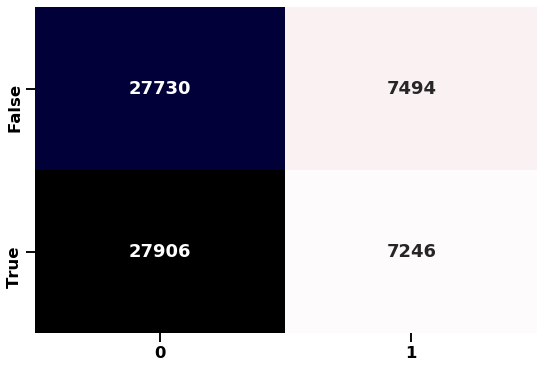


Accuracy:  0.497 

Report:
              precision    recall  f1-score   support

       False       0.50      0.79      0.61     35224
        True       0.49      0.21      0.29     35152

    accuracy                           0.50     70376
   macro avg       0.50      0.50      0.45     70376
weighted avg       0.50      0.50      0.45     70376

Time for [5 - report]: 0:00:00.593957


In [55]:
# 5. Evaluate
with Timer("5 - report"):
    report_training_results(y_dev, y_pred)

In [ ]:
report_training_results(y_dev, y_pred, name=f"Baseline - {run_name}", heatmap=False)
plot_confusion_matrix(y_dev, y_pred, labels=[0, 1], title=f"{run_name} Baseline", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

In [ ]:
with open(fn_run_path / "eval_results_sgd.p", "wb") as fp:
    pickle.dump(y_dev, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# 4. train
with Timer("4 - LogReg (train -> predict)"):
    y_pred = train_test_logreg(X_train_, y_train, X_dev_)

Start on [5 - report] ...
Confusion Matrix:
[[17268 17956]
 [17500 17652]]

CM: [17268 17956 17500 17652] 
[tn, fp, fn, tp]
  accuracy: 0.496
 precision: 0.496
    recall: 0.496
  f1-score: 0.496


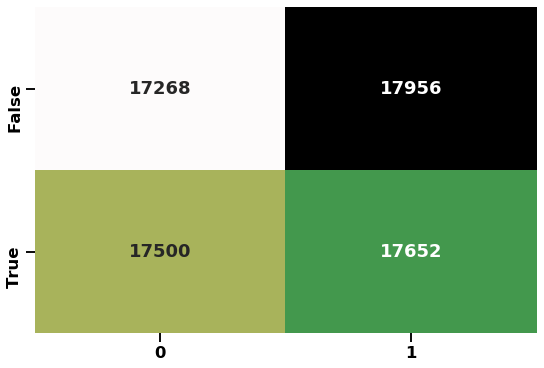


Accuracy:  0.496 

Report:
              precision    recall  f1-score   support

       False       0.50      0.49      0.49     35224
        True       0.50      0.50      0.50     35152

    accuracy                           0.50     70376
   macro avg       0.50      0.50      0.50     70376
weighted avg       0.50      0.50      0.50     70376

Time for [5 - report]: 0:00:00.281662


In [57]:
# 5. Evaluate
with Timer("5 - report"):
    report_training_results(y_dev, y_pred)

In [ ]:
with open(fn_run_path / "eval_results_logreg.p", "wb") as fp:
    pickle.dump(y_dev, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# 4. train
with Timer("4 - SVM (train -> predict)"):
    y_pred = train_test_svm(X_train_, y_train, X_dev_)

In [ ]:
# 5. Evaluate
with Timer("5 - report"):
    report_training_results(y_dev, y_pred)

In [ ]:
with open(fn_run_path / "eval_results_svm.p", "wb") as fp:
    pickle.dump(y_dev, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)